In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

import numpy as np
from pixell import enmap, enplot, reproject
import glob
import matplotlib.pyplot as plt
import emcee, corner
from astropy.io import fits
import sys
from astropy import units as u, constants as const
sys.path.insert(0, '../src')
import sys
import warnings
import os
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import yaml
import itertools
from pixell import enmap

import bandpass as bp
import covariance as cov
import model
import utils as ut

import SZpack as SZ

from astropy.coordinates import SkyCoord
import astropy.units as u

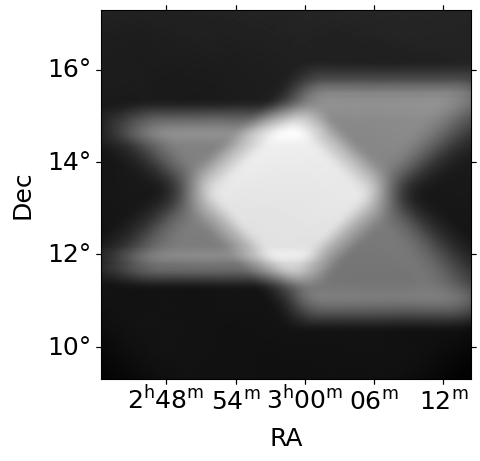

In [2]:
emap = enmap.read_map("/home/gill/research/ACT/bridge/a399_a401/data/act_no_reproj/act_cut_dr6v2_pa5_f098_4way_coadd_ivar.fits")

ax = plt.subplot(projection=emap.wcs)
ax.imshow(emap, origin='lower', cmap='gray')
plt.xlabel('RA')
plt.ylabel('Dec')

In [3]:
# change plt parameters to tex font
plt.rcParams['text.usetex'] = 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.visualization import ImageNormalize

# use latex for the plot
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', size=25)

# Compute ZScale limits
# Create the plot with WCS projection
plt.figure(figsize=(8, 8))

flux_factor = ut.flux_factor("pa5", 98)

emap_jy = emap / flux_factor**2

ax = plt.subplot(projection=emap_jy.wcs)

norm = ImageNormalize(emap_jy, interval=ZScaleInterval())

# Display the map with ZScale normalization
im = ax.imshow(emap_jy, origin='lower', cmap='viridis', norm=norm, interpolation='none')

ra = ax.coords[0]
dec = ax.coords[1]

# Set labels
ra.set_axislabel('Right ascension')
dec.set_axislabel('Declination')

# Ensure tick labels are in float degrees
ra.set_major_formatter('d')
dec.set_major_formatter('d')

ax.invert_xaxis()
plt.colorbar(im,fraction=0.046, pad=0.04, label='(Jy/sr)$^{-2}$')

plt.savefig('../plots/ivar_map.eps', bbox_inches='tight', dpi=300, format='eps')
plt.show()


In [ ]:
def converge_plot(sampler, labels):
    plt.figure(figsize=(12, 8))
    for idx in range(len(labels)):
        chain = sampler.get_chain()[:, :, idx].T

        N = np.exp(np.linspace(np.log(10**2), np.log(chain.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = ut.autocorr_gw2010(chain[:, :n])
            new[i] = ut.autocorr_new(chain[:, :n])

        plt.loglog(N, new, "o-", label=labels[idx])
        plt.xlabel("number of samples, $N$")
        plt.ylabel(r"$\tau$ estimates")
            
    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()
    
def plotter_sim(filename, target, p_range, plot_contours=False, fit_dust=True,
                plot_converge=False, burnin=1, 
                plot_samples=True, truths=None,
                thin=1, plot_maps=False, cf_path="cf_auto_all.yaml"):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Load interpolated function dictionary
    # interp_f_dict = ut.load_interp_funcs()
    
    dire = f"/home/a/ahincks/gillajay/scratch/bridge"
    
    sampler = emcee.backends.HDFBackend(filename)
        
    cf = ut.get_config_file(f'{cf_path}')
        
    labels = [r'$RA_{\rm A401}$', 
              r'$DEC_{\rm A401}$', 
              r'$\beta_{\rm A401}$', 
              r'$r_{\rm c, A401}$ [$^{\prime}$]', 
              r'$e_{\rm A401}$', 
              r'$\theta_{\rm A401}$', 
              r'$\tau_{\rm A401}$', 
              r'$T_{\rm e, A401}$', 
              r'$A_{\rm D, A401}$',
              
              r'$RA_{\rm A399}$', 
              r'$DEC_{\rm A399}$', 
              r'$\beta_{\rm A399}$', 
              r'$r_{\rm c, A399}$ [$^{\prime}$]', 
              r'$e_{\rm A399}$', 
              r'$\theta_{\rm A399}$', 
              r'$\tau_{\rm A399}$', 
              r'$T_{\rm e, A399}$', 
              r'$A_{\rm D, A399}$',
            
              r"$RA_{\rm fil}",
              r"$DEC_{\rm fil}",
              r"$L_{\rm fil}$",
              r"$W_{\rm fil}$",
              r'$\tau_{\rm fil}$',
              r'$T_{\rm e, fil}$',
              r'$A_{\rm D, fil}$',
              
              r"$v_{r, avg}$"]
    
    labels_mode = [r"$RA_{\rm fil} [$^{\circ}$]",
              r"$DEC_{\rm fil} [$^{\circ}$]",
              r"$L_{\rm fil}$ [$^{\prime}$]",
              r"$W_{\rm fil}$ [$^{\prime}$]",
              r'$\tau_{\rm fil}$',
              r'$T_{\rm e, fil}$ [keV]',
              r'$A_{\rm D, fil}$ [Jy/sr]']
    
    #labels_mode = [r"$DEC_{\rm fil}", r'$A_{\rm D, fil}$']
    
    labels_a401 = [r'RA$_{\rm A401}$ [$^{\circ}$]', 
              r'DEC$_{\rm A401}$ [$^{\circ}$]', 
              r'$\beta_{\rm A401}$', 
              r'$r_{\rm c, A401}$ [$^{\prime}$]', 
              r'$e_{\rm A401}$', 
              r'$\theta_{\rm A401}$ [$^{\circ}$]', 
              r'$\tau_{\rm A401}$', 
              r'$T_{\rm e, A401}$ [keV]', 
              r'$A_{\rm D, A401}$ [Jy/sr]',
              r"$v_{\rm r, avg}$ [km/s]"]
    
    labels_a399 = [r'$RA_{\rm A399}$ [$^{\circ}$]', 
              r'$DEC_{\rm A399}$ [$^{\circ}$]', 
              r'$\beta_{\rm A399}$', 
              r'$r_{\rm c, A399}$ [$^{\prime}$]', 
              r'$e_{\rm A399}$', 
              r'$\theta_{\rm A399}$ [$^{\circ}$]', 
              r'$\tau_{\rm A399}$', 
              r'$T_{\rm e, A399}$ [keV]', 
              r'$A_{\rm D, A399}$ [Jy/sr]',
              r"$v_{\rm r, avg}$ [km/s]"]
    
    labels_fil =  [r"$RA_{\rm fil}$ [$^{\circ}$]",
              r"$DEC_{\rm fil}$ [$^{\circ}$]",
              r"$L_{\rm fil}$ [$^{\prime}$]",
              r"$W_{\rm fil}$ [$^{\prime}$]",
              r'$\tau_{\rm fil}$',
              r'$T_{\rm e, fil}$ [keV]',
              r'$A_{\rm D, fil}$ [Jy/sr]',
              
              r"$v_{\rm r, avg}$ [km/s]"]
    
            
    region = ut.get_region(cf['region_center_ra'], 
                           cf['region_center_dec'], 
                           cf['region_width'])
    
    dire_data = "/home/gill/research/ACT/bridge/data_paper/data/data/act_no_reproj"
    data_ref = enmap.read_map(f"{dire_data}/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits", 
                              box=region)
    
    data_wcs = data_ref.wcs
    
    idx_ra_401_pix = 0
    idx_dec_401_pix = 1
    
    idx_ra_399_pix = 9
    idx_dec_399_pix = 10
    
    idx_ra_fil_pix = 18
    idx_dec_fil_pix = 19
    
    samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
    
    print("\nNumber of iterations: {:.0f}".format(samples.shape[0] / sampler.shape[0]))

    
    a401_ra_pix = samples[:, idx_ra_401_pix]
    a401_dec_pix = samples[:, idx_dec_401_pix]
    
    a399_ra_pix = samples[:, idx_ra_399_pix]
    a399_dec_pix = samples[:, idx_dec_399_pix]
    
    fil_ra_pix = samples[:, idx_ra_fil_pix]
    fil_dec_pix = samples[:, idx_dec_fil_pix]
    
    ra_a401 = data_ref.wcs.celestial.wcs_pix2world(a401_ra_pix, a401_dec_pix, 0)[0]
    dec_a401 = data_ref.wcs.celestial.wcs_pix2world(a401_ra_pix, a401_dec_pix, 0)[1]
      
    ra_a399 = data_ref.wcs.celestial.wcs_pix2world(a399_ra_pix, a399_dec_pix, 0)[0]
    dec_a399 = data_ref.wcs.celestial.wcs_pix2world(a399_ra_pix, a399_dec_pix, 0)[1]
        
    ra_fil = data_ref.wcs.celestial.wcs_pix2world(fil_ra_pix, fil_dec_pix, 0)[0]
    dec_fil = data_ref.wcs.celestial.wcs_pix2world(fil_ra_pix, fil_dec_pix, 0)[1]

    # print("\nA401")
    # print("RA: {:.6f}, +/- {:.6f}".format(np.mean(ra_a401), np.std(ra_a401)))
    # print("DEC: {:.6f}, +/- {:.6f}".format(np.mean(dec_a401), np.std(dec_a401)))

    # print("\nA399")
    # print("RA: {:.6f}, +/- {:.6f}".format(np.mean(ra_a399), np.std(ra_a399)))
    # print("DEC: {:.6f}, +/- {:.6f}".format(np.mean(dec_a399), np.std(dec_a399)))

    # print("\nFilament")
    # print("RA: {:.6f}, +/- {:.6f}".format(np.mean(ra_fil), np.std(ra_fil)))
    # print("DEC: {:.6f}, +/- {:.6f}".format(np.mean(dec_fil), np.std(dec_fil)))
    
    samples[:, idx_ra_401_pix] = ra_a401
    samples[:, idx_dec_401_pix] = dec_a401

    samples[:, idx_ra_399_pix] = ra_a399
    samples[:, idx_dec_399_pix] = dec_a399
    
    samples[:, idx_ra_fil_pix] = ra_fil
    samples[:, idx_dec_fil_pix] = dec_fil
    
    samples[:, 20] *= 0.5
    samples[:, 21] *= 0.5
    
    columns_a401 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 25]
    columns_a399 = [9, 10, 11, 12, 13, 14, 15, 16, 17, 25]
    columns_fil = [18, 19, 20, 21, 22, 23, 24, 25]
    
    samples_short = samples[:, columns_a401]
    
    theta = []
    
    for idx, label in enumerate(labels):
        mcmc_run = np.percentile(samples[:, idx], [16, 50, 84])
        err = .5 * (mcmc_run[2] - mcmc_run[0])
                
        #if label in labels_mode:
        data = samples[:, idx]

        # Calculate bin width using Freedman-Diaconis rule
        n = len(data)
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        bin_width = 2 * iqr * n**(-1/3)

        # Calculate number of bins using bin width
        num_bins = int((np.max(data) - np.min(data)) / bin_width)

        # Create histogram
        hist, bin_edges = np.histogram(data, bins=num_bins, density=True)

        # Find bin with maximum value (estimate of mode)
        mode_bin = np.argmax(hist)
        mode_value = 0.5 * (bin_edges[mode_bin] + bin_edges[mode_bin + 1])

        mean = mode_value
        
#         else:
#             mean = mcmc_run[1]
        
        theta.append(mean)

        print("{}: {:.6f}, +/- {:.6f}".format(label, mean, err))

    truths = np.array(theta)
    #truths = None
    
    if plot_contours: 
        levels = (1 - np.exp(-0.5), 1 - np.exp(-2) )
        if truths is not None:
            figure = corner.corner(samples, 
                                   labels=labels,
                                   truths=truths,
                                   #range=p_range,                                  
                                   show_titles=False, 
                                   plot_datapoints=0,
                                   title_fmt=".3f")
            
            figure.subplots_adjust(right=3,top=3)
            
            ax = figure.gca()
            # plt.text(-5, 5, 'Preliminary', transform=ax.transAxes,
            #     fontsize=300, color='gray', alpha=0.2,
            #     ha='center', va='center', rotation=30)
            
            for ax in figure.get_axes():
              #ax.tick_params(axis='both', which='major', labelsize=14)
              #ax.tick_params(axis='both', which='minor', labelsize=12)    
                ax.tick_params(axis='both', labelsize=40)
                ax.xaxis.label.set_size(60)
                ax.yaxis.label.set_size(60)
            
            
            # save figure
            figure.savefig("../plots/corner_a401.pdf", dpi=500, bbox_inches='tight')

            #figure.savefig("plots/corner_fil.pdf", dpi=500, bbox_inches='tight')
        else:
            figure = corner.corner(samples, 
                       labels=labels,
                       #quantiles=[0.16, 0.5, 0.84],
                       show_titles=False, 
                       #range=p_range,
                       plot_datapoints=False,
                       title_fmt=".3f")
            figure.subplots_adjust(right=3,top=3)
                        
            ax = figure.gca()
            # plt.text(-5, 5, 'Preliminary', transform=ax.transAxes,
            #     fontsize=300, color='gray', alpha=0.2,
            #     ha='center', va='center', rotation=30)
            
            for ax in figure.get_axes():
              #ax.tick_params(axis='both', which='major', labelsize=14)
              #ax.tick_params(axis='both', which='minor', labelsize=12)    
                ax.tick_params(axis='both', labelsize=40)
                ax.xaxis.label.set_size(60)
                ax.yaxis.label.set_size(60)
                
        plt.show()

    if plot_converge:
        print("Convergence plot")
        converge_plot(sampler, labels_a401)

In [ ]:
target = "bridge"

p_range_a401 = [(44.736, 44.746),
               (13.57, 13.59),
               (0.9, 1.4),
               (2, 4.8),
               (1, 1.7),
               (80, 140),
               (.0078, .014),
               (7.5, 9.5),
               (-1e5, 501400.053986 * 2.5),
               (1000, 3200)]

p_range_a399 = [(44.45, 44.476),
               (13.025, 13.052),
               (.9, 1.8),
               (2, 7.5),
               (.6, 1.6),
               (0, 180),
               (.0038, .0072),
               (6.8, 7.7),
               (-50e3, 700e3),
               (-2500, 2500)]

    
#     labels_fil =  [r"$RA_{\rm fil}",
#               r"$DEC_{\rm fil}",
#               r"$L_{\rm fil}$",
#               r"$W_{\rm fil}$",
#               r'$\tau_{\rm fil}$',
#               r'$T_{\rm e, fil}$',
#               r'$A_{\rm D, fil}$',
              
#               r"$v_{r, avg}$"]

p_range_fil = [(44.55, 44.8),
               (13.2, 13.5),
               (8, 20),
               (10, 18),
               (.0008, 0.0021),
               (5.2, 7.5),
               (-25e3, 200e3),
               (1000, 4500)]

model_tot= plotter_sim(filename=f"/home/gill/research/ACT/bridge/results/ajay/case46/chain.h5", 
                       target=f"{target}",
                       plot_maps=1,
                       burnin=200,
                       thin=1,
                       fit_dust=1,
                       plot_contours=1,
                       p_range=p_range_a401,
                       plot_samples=0,
                       cf_path="/home/gill/research/ACT/multi-freq-bridge/configs/case46_ajay.yaml",
                       plot_converge=0)

In [ ]:
Number of iterations: 13656
$RA_{\rm A401}$: 44.741279, +/- 0.001608
$DEC_{\rm A401}$: 13.577833, +/- 0.002167
$\beta_{\rm A401}$: 1.081222, +/- 0.075397
$r_{\rm c, A401}$ [$^{\prime}$]: 3.152839, +/- 0.395240
$e_{\rm A401}$: 1.324916, +/- 0.117789
$\theta_{\rm A401}$: 109.795009, +/- 6.667116
$\tau_{\rm A401}$: 0.010361, +/- 0.000716
$T_{\rm e, A401}$: 8.495815, +/- 0.245556
$A_{\rm D, A401}$: 97293.346391, +/- 200132.274262
$RA_{\rm A399}$: 44.463061, +/- 0.003117
$DEC_{\rm A399}$: 13.039613, +/- 0.003519
$\beta_{\rm A399}$: 0.936454, +/- 0.065619
$r_{\rm c, A399}$ [$^{\prime}$]: 3.098175, +/- 0.462653
$e_{\rm A399}$: 1.157243, +/- 0.125563
$\theta_{\rm A399}$: 116.608116, +/- 14.004839
$\tau_{\rm A399}$: 0.008372, +/- 0.000674
$T_{\rm e, A399}$: 7.182108, +/- 0.190611
$A_{\rm D, A399}$: 5184.614229, +/- 140825.740495
$RA_{\rm fil}: 44.672408, +/- 0.019142
$DEC_{\rm fil}: 13.341570, +/- 0.027347
$L_{\rm fil}$: 14.581966, +/- 1.939244
$W_{\rm fil}$: 12.024050, +/- 1.127387
$\tau_{\rm fil}$: 0.001331, +/- 0.000172
$T_{\rm e, fil}$: 6.537729, +/- 0.350609
$A_{\rm D, fil}$: 778.267073, +/- 63033.310746
$v_{r, avg}$: 2497.934170, +/- 312.632446

In [ ]:
Number of iterations: 16662
$RA_{\rm A401}$: 44.741065, +/- 0.001514
$DEC_{\rm A401}$: 13.578850, +/- 0.002066
$\beta_{\rm A401}$: 1.094965, +/- 0.074308
$r_{\rm c, A401}$ [$^{\prime}$]: 3.136663, +/- 0.375450
$e_{\rm A401}$: 1.337288, +/- 0.106835
$\theta_{\rm A401}$: 109.929819, +/- 6.220435
$\tau_{\rm A401}$: 0.010449, +/- 0.000679
$T_{\rm e, A401}$: 8.525355, +/- 0.248107
$A_{\rm D, A401}$: 86092.623599, +/- 188450.700481
$RA_{\rm A399}$: 44.463598, +/- 0.002966
$DEC_{\rm A399}$: 13.038696, +/- 0.003240
$\beta_{\rm A399}$: 1.053455, +/- 0.239253
$r_{\rm c, A399}$ [$^{\prime}$]: 3.469339, +/- 0.587106
$e_{\rm A399}$: 1.162149, +/- 0.123363
$\theta_{\rm A399}$: 111.713122, +/- 14.681799
$\tau_{\rm A399}$: 0.008354, +/- 0.000845
$T_{\rm e, A399}$: 7.224879, +/- 0.182117
$A_{\rm D, A399}$: 8855.587065, +/- 152083.536100
$RA_{\rm fil}: 44.666543, +/- 0.037024
$DEC_{\rm fil}: 13.341406, +/- 0.056074
$L_{\rm fil}$: 15.514648, +/- 4.528076
$W_{\rm fil}$: 12.760684, +/- 1.144964
$\tau_{\rm fil}$: 0.001368, +/- 0.000163
$T_{\rm e, fil}$: 6.343114, +/- 0.344954
$A_{\rm D, fil}$: 520.022570, +/- 45837.267548
$v_{r, avg}$: 2552.610171, +/- 313.807366

data_orig_98 = enmap.read_map(")

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


from astropy.visualization import (ZScaleInterval,
                                    PercentileInterval,
                                    MinMaxInterval,
                                    ImageNormalize,
                                    simple_norm)
from matplotlib.ticker import MaxNLocator

region_center_ra = 44.5916744
region_center_dec = 13.2999979

box_region = ut.get_region(region_center_ra, region_center_dec, 3.1 * 1.9)

data_map_pl = ut.imap_dim_check(enmap.read_map("/home/gill/research/ACT/bridge/data_paper/data/data/act_no_reproj/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits",
                                               box=box_region))

flux_factor = ut.flux_factor("pa5", 98) # (Jy/sr/uK)

data_map_pl *= flux_factor / 1000

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=data_map_pl.wcs)

norm = ImageNormalize(data_map_pl, interval=ZScaleInterval())

im = ax.imshow(data_map_pl, origin='lower', cmap='viridis', norm=norm, interpolation='none')
# Access coordinate axes
ra = ax.coords[0]
dec = ax.coords[1]
color = 'white'

x_center = region_center_ra
y_center = region_center_dec

# Set labels
ra.set_axislabel('Right ascension')
dec.set_axislabel('Declination')

# Ensure tick labels are in float degrees
ra.set_major_formatter('d')
dec.set_major_formatter('d')

ax.invert_xaxis()

divider = make_axes_locatable(ax)

cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='kJy/sr')
# cbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

# make boxes of 1.9 deg x 1.9 deg around the central region and around it
import matplotlib.patches as patches

box_size = 1.9  # size of each box in degrees
# Create a 3x3 grid of boxes centered on (x_center, y_center) and label them
region_counter = 0

for dy_offset in [box_size, 0, -box_size]:
    for dx_offset in [box_size, 0, -box_size]:
        lower_left = (x_center + dx_offset - box_size/2, y_center + dy_offset - box_size/2)
        rect = patches.Rectangle(lower_left, box_size, box_size, 
                                 edgecolor=color, facecolor='none', lw=1,
                                 transform=ax.get_transform('world'))
        ax.add_patch(rect)
        
        label_x = lower_left[0] + box_size/2
        label_y = lower_left[1] + 0.8 * box_size
        
        if dx_offset == 0 and dy_offset == 0:
            label = "Cluster pair"
        else:
            label = f"Region {region_counter}"
            region_counter += 1
        
        ax.text(label_x, label_y, label, color=color, fontsize=14,
                ha='center', va='bottom', transform=ax.get_transform('world'))

plt.savefig("../plots/region_map.eps", bbox_inches='tight', dpi=300, format='eps')
plt.show()

In [ ]:
cax = divider.append_axes("bottom", size="5%", pad=0.2)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label='kJy/sr')
cbar.ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

In [ ]:
data_orig_98 = ut.imap_dim_check(enmap.read_map("/home/gill/research/ACT/bridge/data_paper/data/data/20210728/dr6v2_pa5_f090_4way_set1_map_srcfree.fits"))
data_fit_98 = ut.imap_dim_check(enmap.read_map("/home/gill/research/ACT/bridge/data_paper/data/data/act_no_reproj/act_cut_dr6v2_pa5_f098_4way_set1_map_srcfree.fits"))

ut.plot_image(data_orig_98 - data_fit_98, interval_type="zscale")
ut.plot_image(data_fit_98)

ratio =  data_fit_98 / data_orig_98
print(np.nanmean(ratio), np.nanstd(ratio))

In [ ]:
# map maker

def map_maker(mcmc_fname, cf_name, labels, burnin=1, thin=1):
    sampler = emcee.backends.HDFBackend(mcmc_fname)
    samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)  
    cf = ut.get_config_file(cf_name)
    
    # turn tex on for plots
    plt.rc('text', usetex=True)
    plt.rc('font', family='sans-serif', size=20)
              
    region = ut.get_region(cf['region_center_ra'], 
                           cf['region_center_dec'], 
                           cf['region_width'])
    
    dire_data = "/home/gill/research/ACT/bridge/data_paper/data/data/act_no_reproj"
    dire_data_planck = "/home/gill/research/ACT/bridge/data_paper/data/data/planck_no_reproj"

    data_ref = ut.imap_dim_check(enmap.read_map(f"{dire_data}/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits", 
                                 box=region))
    
    data_wcs = data_ref.wcs
    data_shape = data_ref.shape
    theta = []
    pad = 0.17

    for idx, label in enumerate(labels):
        mcmc_run = np.percentile(samples[:, idx], [16, 50, 84])
        err = .5 * (mcmc_run[2] - mcmc_run[0])
                
        data = samples[:, idx]

        n = len(data)
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        bin_width = 2 * iqr * n**(-1/3)

        num_bins = int((np.max(data) - np.min(data)) / bin_width)

        hist, bin_edges = np.histogram(data, bins=num_bins, density=True)

        mode_bin = np.argmax(hist)
        mode_value = 0.5 * (bin_edges[mode_bin] + bin_edges[mode_bin + 1])

        mean = mode_value
        
        theta.append(mean)

        print("{}: {:.6f}, +/- {:.6f}".format(label, mean, err))
    
    c1 = model.Cluster(theta=theta, name="abell401", model_choice=cf["model_choice"])
    c2 = model.Cluster(theta=theta, name="abell399", model_choice=cf["model_choice"])
    fil = model.Filament(theta=theta, model_choice=cf["model_choice"])

    # 30
    freq = 30
    array = "npipe"
    inst = "planck"

    ref_data_30 = ut.imap_dim_check(enmap.read_map(f"{dire_data_planck}/planck_npipe_030_coadd_map_srcfree.fits", 
                                                      box=region))

    xgrid, ygrid = np.meshgrid(np.arange(0, data_shape[1], 1), np.arange(0, data_shape[0], 1))
    flux_factor_30 = ut.flux_factor(array, freq)
    ref_data_30 *= flux_factor_30

    c1_model = c1.szmodel(frequency=freq, 
                            array=array, 
                            z=cf['c1_z'],
                            muo=cf['c1_muo'],
                            xgrid=xgrid, 
                            ygrid=ygrid,
                            ellipticity_type=cf["ellipticity_type"])
    
    c2_model = c2.szmodel(frequency=freq,
                            array=array,
                            z=cf['c2_z'],
                            muo=cf['c2_muo'],
                            xgrid=xgrid,
                            ygrid=ygrid, 
                            ellipticity_type=cf["ellipticity_type"])
    
    fil_model = fil.szmodel(frequency=freq,
                            array=array,
                            xgrid=xgrid,
                            ygrid=ygrid, 
                            z=cf['fil_z'],
                            muo=cf['fil_muo'])
    
    total_model = (c1_model + c2_model + fil_model) 

    beam_30 = ut.get_2d_beam(data_shape=ref_data_30.shape, 
                             freq=freq, 
                             array=array, 
                             inst=inst, 
                             version="dr6v2",
                             data_wcs=data_wcs)
    
    model_tot_30 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_30))

    # 98
    freq = 98
    array = "pa5"

    ref_data_98 = ut.imap_dim_check(enmap.read_map(f"{dire_data}/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits", 
                                                   box=region))

    xgrid, ygrid = np.meshgrid(np.arange(0, data_shape[1], 1), np.arange(0, data_shape[0], 1))
    flux_factor_98 = ut.flux_factor(array, freq)
    ref_data_98 *= flux_factor_98

    c1_model = c1.szmodel(frequency=freq, 
                            array=array, 
                            z=cf['c1_z'],
                            muo=cf['c1_muo'],
                            xgrid=xgrid, 
                            ygrid=ygrid,
                            ellipticity_type=cf["ellipticity_type"])
    
    c2_model = c2.szmodel(frequency=freq,
                            array=array,
                            z=cf['c2_z'],
                            muo=cf['c2_muo'],
                            xgrid=xgrid,
                            ygrid=ygrid, 
                            ellipticity_type=cf["ellipticity_type"])
    
    fil_model = fil.szmodel(frequency=freq,
                            array=array,
                            xgrid=xgrid,
                            ygrid=ygrid, 
                            z=cf['fil_z'],
                            muo=cf['fil_muo'])
    
    total_model = (c1_model + c2_model + fil_model) 

    beam_98 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
                             freq=freq, 
                             array=array, 
                             inst='act', 
                             version="dr6v2",
                             data_wcs=data_wcs)
    
    model_tot_98 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_98))

    # PLOTS
    lab = f"$I$ [kJy / sr]"

    fig = plt.figure(figsize=(12, 6)) # create the canvas for plotting

    nrows = 1
    ncols = 3

    inst_dict = {'30':'Planck', '44':'Planck', '70':'Planck',
                 '100':'Planck', '143':'Planck', '217':'Planck',
                 '353':'Planck', "545":'Planck', "857":'Planck',
                 "98":'ACT', "150":'ACT', "220":'ACT'}

    array_dict = {'30':'npipe', '44':'npipe', '70':'npipe',
                  '100':'npipe', '143':'npipe', '217':'npipe',
                  '353':'npipe', "545":'npipe', "857":'npipe',
                  "98":'pa5', "150":'pa5', "220":'pa4'}
    
    ref_data_dict = {'98':ref_data_98}
    model_tot_dict = {'98':model_tot_98}

    freqs = ['30', '44', '70', '98', '100', '143', '150', '217', '220', '353', '545', '857']

    inst_dict = {'98':"ACT", "150":"ACT", "220":"ACT", 
                 "30":"Planck", "44":"Planck", "70":"Planck",
                 "100":"Planck", "143":"Planck", 
                 "217":"Planck", "353": "Planck", "545":"Planck"}
    freqs = ['98']

    for i, freq in enumerate(freqs):
                        
        ref_data = ref_data_dict[freq]
        model_tot = model_tot_dict[freq]
        
        ax1 = fig.add_subplot(nrows, ncols, i*3+1, projection=data_ref.wcs)
        im1 = ax1.imshow(ref_data / 10**3, origin='lower')
        ax1.invert_xaxis()
        cb1 = fig.colorbar(im1, cmap='viridis', ax=ax1, orientation="horizontal", pad=pad)
        cb1.set_label(lab)
        ax1.set_ylabel('Declination')
        ax1.set_xlabel('Right ascension')
        ax1.set_title(f"Data, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=20)
        
        ax = fig.gca()
        ra = ax.coords[0]
        ra.set_format_unit("degree")
        
        ax2 = fig.add_subplot(nrows, ncols, i*3+2, projection=data_ref.wcs)
        im2 = ax2.imshow(model_tot / 10**3, origin='lower')
        ra = ax2.coords[0]
        ra.set_format_unit("degree")
        ax2.invert_xaxis()
        # Remove y label and y tick labels in the middle panel
        ax2.set_ylabel('')
        ax2.set_yticklabels([])

        ax2.coords[1].set_ticklabel_visible(False)

        cb2 = fig.colorbar(im2, cmap='viridis', ax=ax2, orientation="horizontal", pad=pad)
        cb2.set_label(lab)
        ax2.set_xlabel('Right ascension')
        ax2.set_title(f"Model, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=20)
        
        ax3 = fig.add_subplot(nrows, ncols, i*3+3, projection=data_ref.wcs)
        im3 = ax3.imshow((ref_data - model_tot) / 10**3, origin='lower')
        ax3.invert_xaxis()
        # Remove y label and y tick labels in the right panel
        ax3.set_ylabel('')
        ax3.set_yticklabels([])
        ax3.coords[1].set_ticklabel_visible(False)
        
        cb3 = fig.colorbar(im3, cmap='viridis', ax=ax3, orientation="horizontal", pad=pad)
        cb3.set_label(lab)
        ax3.set_xlabel('Right ascension')
        ax3.set_title(f"Residual, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=20)
        
        #ax = fig.gca()
        #ra = ax.coords[0]
        #ra.set_format_unit("degree")
        # plt.text(.55, .1, 'Preliminary', transform=ax.transAxes,
        # fontsize=40, color='white', alpha=0.7,
        # ha='center', va='center', rotation=0)
        
        # plt.text(-1, .1, 'Preliminary', transform=ax.transAxes,
        # fontsize=40, color='white', alpha=0.7,
        # ha='center', va='center', rotation=0)
        
        # plt.text(-2.6, .1, 'Preliminary', transform=ax.transAxes,
        # fontsize=40, color='white', alpha=0.7,
        # ha='center', va='center', rotation=0)
        
        # fig.subplots_adjust(wspace=0, hspace=0)
        #plt.tight_layout()
        #plt.savefig(f"figs/bridge_220.pdf", bbox_inches='tight', dpi=400)
        plt.savefig(f"../plots/bridge_{freq}.pdf", bbox_inches='tight', dpi=400)
        plt.show()

$RA_{\rm A401}$: 131.978330, +/- 0.177262
$DEC_{\rm A401}$: 147.603440, +/- 0.244421
$\beta_{\rm A401}$: 1.099759, +/- 0.073295
$r_{\rm c, A401}$ [$^{\prime}$]: 3.245899, +/- 0.367404
$e_{\rm A401}$: 1.301426, +/- 0.104980
$\theta_{\rm A401}$: 108.031096, +/- 6.104603
$\tau_{\rm A401}$: 0.010841, +/- 0.000667
$T_{\rm e, A401}$: 8.510661, +/- 0.245249
$A_{\rm D, A401}$: 501326.488238, +/- 262714.633331
$RA_{\rm A399}$: 98.623035, +/- 0.360058
$DEC_{\rm A399}$: 82.949100, +/- 0.406957
$\beta_{\rm A399}$: 0.908858, +/- 0.047476
$r_{\rm c, A399}$ [$^{\prime}$]: 3.428288, +/- 0.425432
$e_{\rm A399}$: 1.173126, +/- 0.122062
$\theta_{\rm A399}$: 121.681261, +/- 17.240144
$\tau_{\rm A399}$: 0.008439, +/- 0.000609
$T_{\rm e, A399}$: 7.157906, +/- 0.188738
$A_{\rm D, A399}$: 4386.067505, +/- 203457.864333
$RA_{\rm fil}: 124.035833, +/- 2.486877
$DEC_{\rm fil}: 122.140025, +/- 3.183554
$L_{\rm fil}$: 27.602176, +/- 3.600809
$W_{\rm fil}$: 25.943973, +/- 2.465843
$\tau_{\rm fil}$: 0.001291, +/- 0.

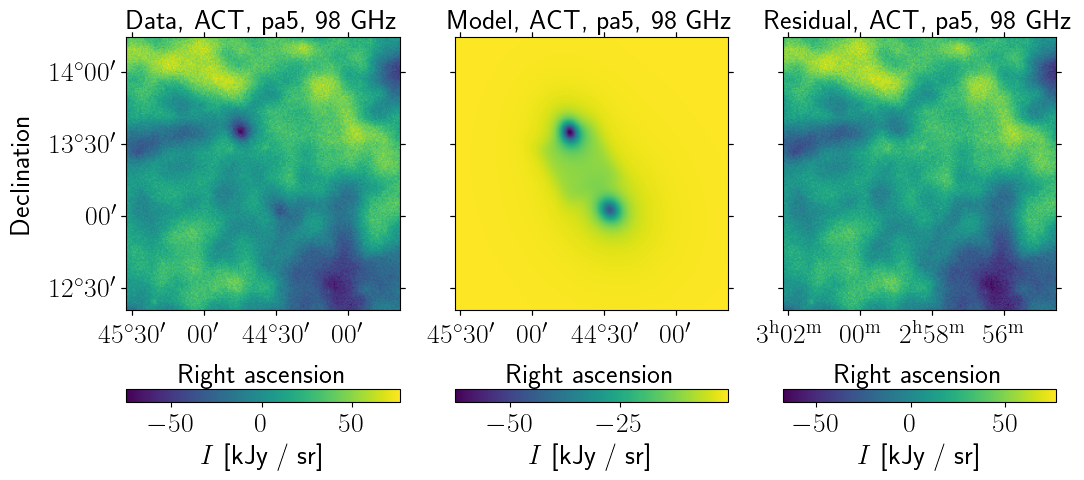

In [72]:
labels = [r'$RA_{\rm A401}$', 
            r'$DEC_{\rm A401}$', 
            r'$\beta_{\rm A401}$', 
            r'$r_{\rm c, A401}$ [$^{\prime}$]', 
            r'$e_{\rm A401}$', 
            r'$\theta_{\rm A401}$', 
            r'$\tau_{\rm A401}$', 
            r'$T_{\rm e, A401}$', 
            r'$A_{\rm D, A401}$',
            
            r'$RA_{\rm A399}$', 
            r'$DEC_{\rm A399}$', 
            r'$\beta_{\rm A399}$', 
            r'$r_{\rm c, A399}$ [$^{\prime}$]', 
            r'$e_{\rm A399}$', 
            r'$\theta_{\rm A399}$', 
            r'$\tau_{\rm A399}$', 
            r'$T_{\rm e, A399}$', 
            r'$A_{\rm D, A399}$',
            
            r"$RA_{\rm fil}",
            r"$DEC_{\rm fil}",
            r"$L_{\rm fil}$",
            r"$W_{\rm fil}$",
            r'$\tau_{\rm fil}$',
            r'$T_{\rm e, fil}$',
            r'$A_{\rm D, fil}$',
            
            r"$v_{r, avg}$"]

map_maker(mcmc_fname="/home/gill/research/ACT/bridge/results/test8/chain.h5",
          cf_name="/home/gill/research/ACT/bridge/results/test8/config.yaml",
          labels=labels,
          burnin=5000,
          thin=1)